In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import scipy.stats as st
from smt.sampling_methods import LHS

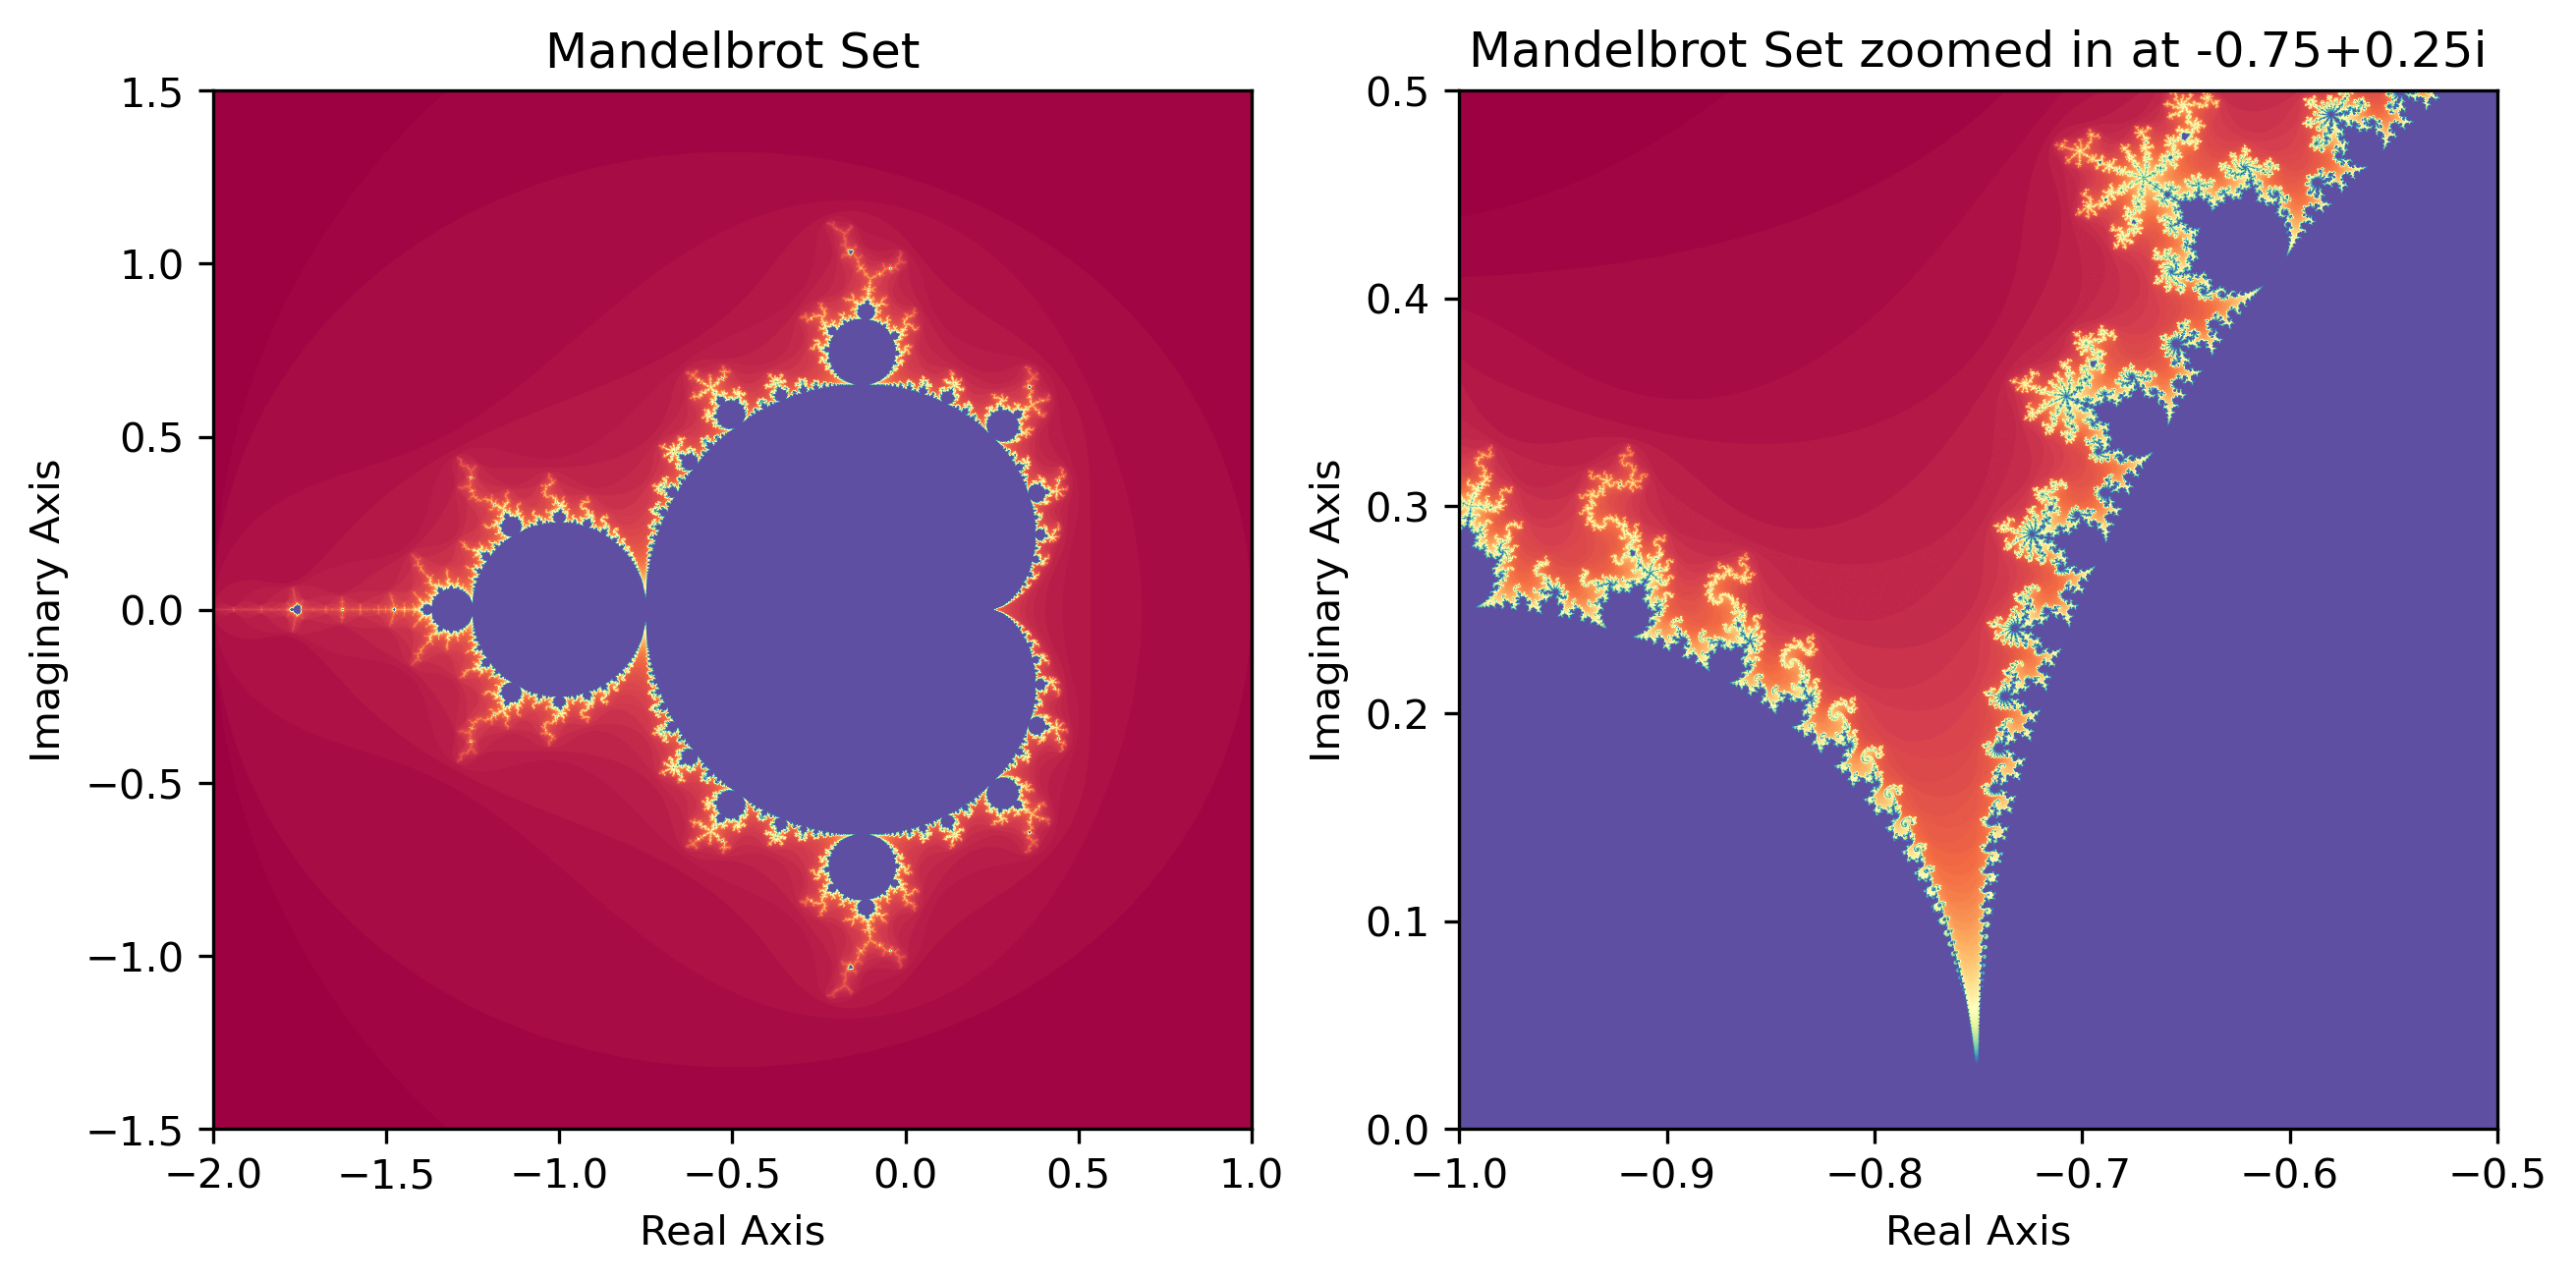

In [2]:
@jit
def mandelbrot(a,b,max_iter):
    c = complex(a,b)
    z = 0.0j
    
    for i in range(max_iter):
        z = z*z + c
        if(abs(z) >= 2):
            return i
        
    return max_iter

columns = 2000 #Resolution of image
rows = 2000

mand = np.zeros([rows, columns]) #variable that stores the critical iterations
mand_zoom = np.zeros([rows, columns]) #for the zoomed plot

for row_index, Re in enumerate(np.linspace(-2, 1, num=rows)):  #Real axis points
    for column_index, Im in enumerate(np.linspace(-1.5, 1.5, num=columns)):  #Imaginary axis points
        mand[row_index, column_index] = mandelbrot(Re, Im, 100)   # maxiteration of 100
        
for row_index, Re in enumerate(np.linspace(-1, -0.5, num=rows)):  #zoom on the sea horse valley
    for column_index, Im in enumerate(np.linspace(0, 0.5, num=columns)):  
        mand_zoom[row_index, column_index] = mandelbrot(Re, Im, 100)   
        
fig = plt.figure(figsize=(10,6), dpi =300)
plt.subplot(121)
plt.imshow(mand.T, cmap='Spectral', extent=[-2, 1, -1.5, 1.5])
plt.xlabel('Real Axis')
plt.ylabel('Imaginary Axis')
plt.title('Mandelbrot Set')

plt.subplot(122)      
plt.imshow(np.flipud(mand_zoom.T), cmap='Spectral', extent=[-1, -0.5, 0, 0.5])
plt.xlabel('Real Axis')
plt.ylabel('Imaginary Axis')
plt.title('Mandelbrot Set zoomed in at -0.75+0.25i')
plt.show()

In [3]:
#function that checks if our sample point is in mandelbrot set or not

def mandel_val(a,b,max_iter):   
    
    c = complex(a,b)
    z = 0.0j
    i = 0
    for i in range(max_iter):
        z = z*z + c
        if(abs(z) >= 2):
            return 0
    
    return c   

Limiting Area:  1.5433536 
Limiting Variance:  0.043910135767040004 
95% confidence interval:  (1.537544766710873, 1.5491624332891272)


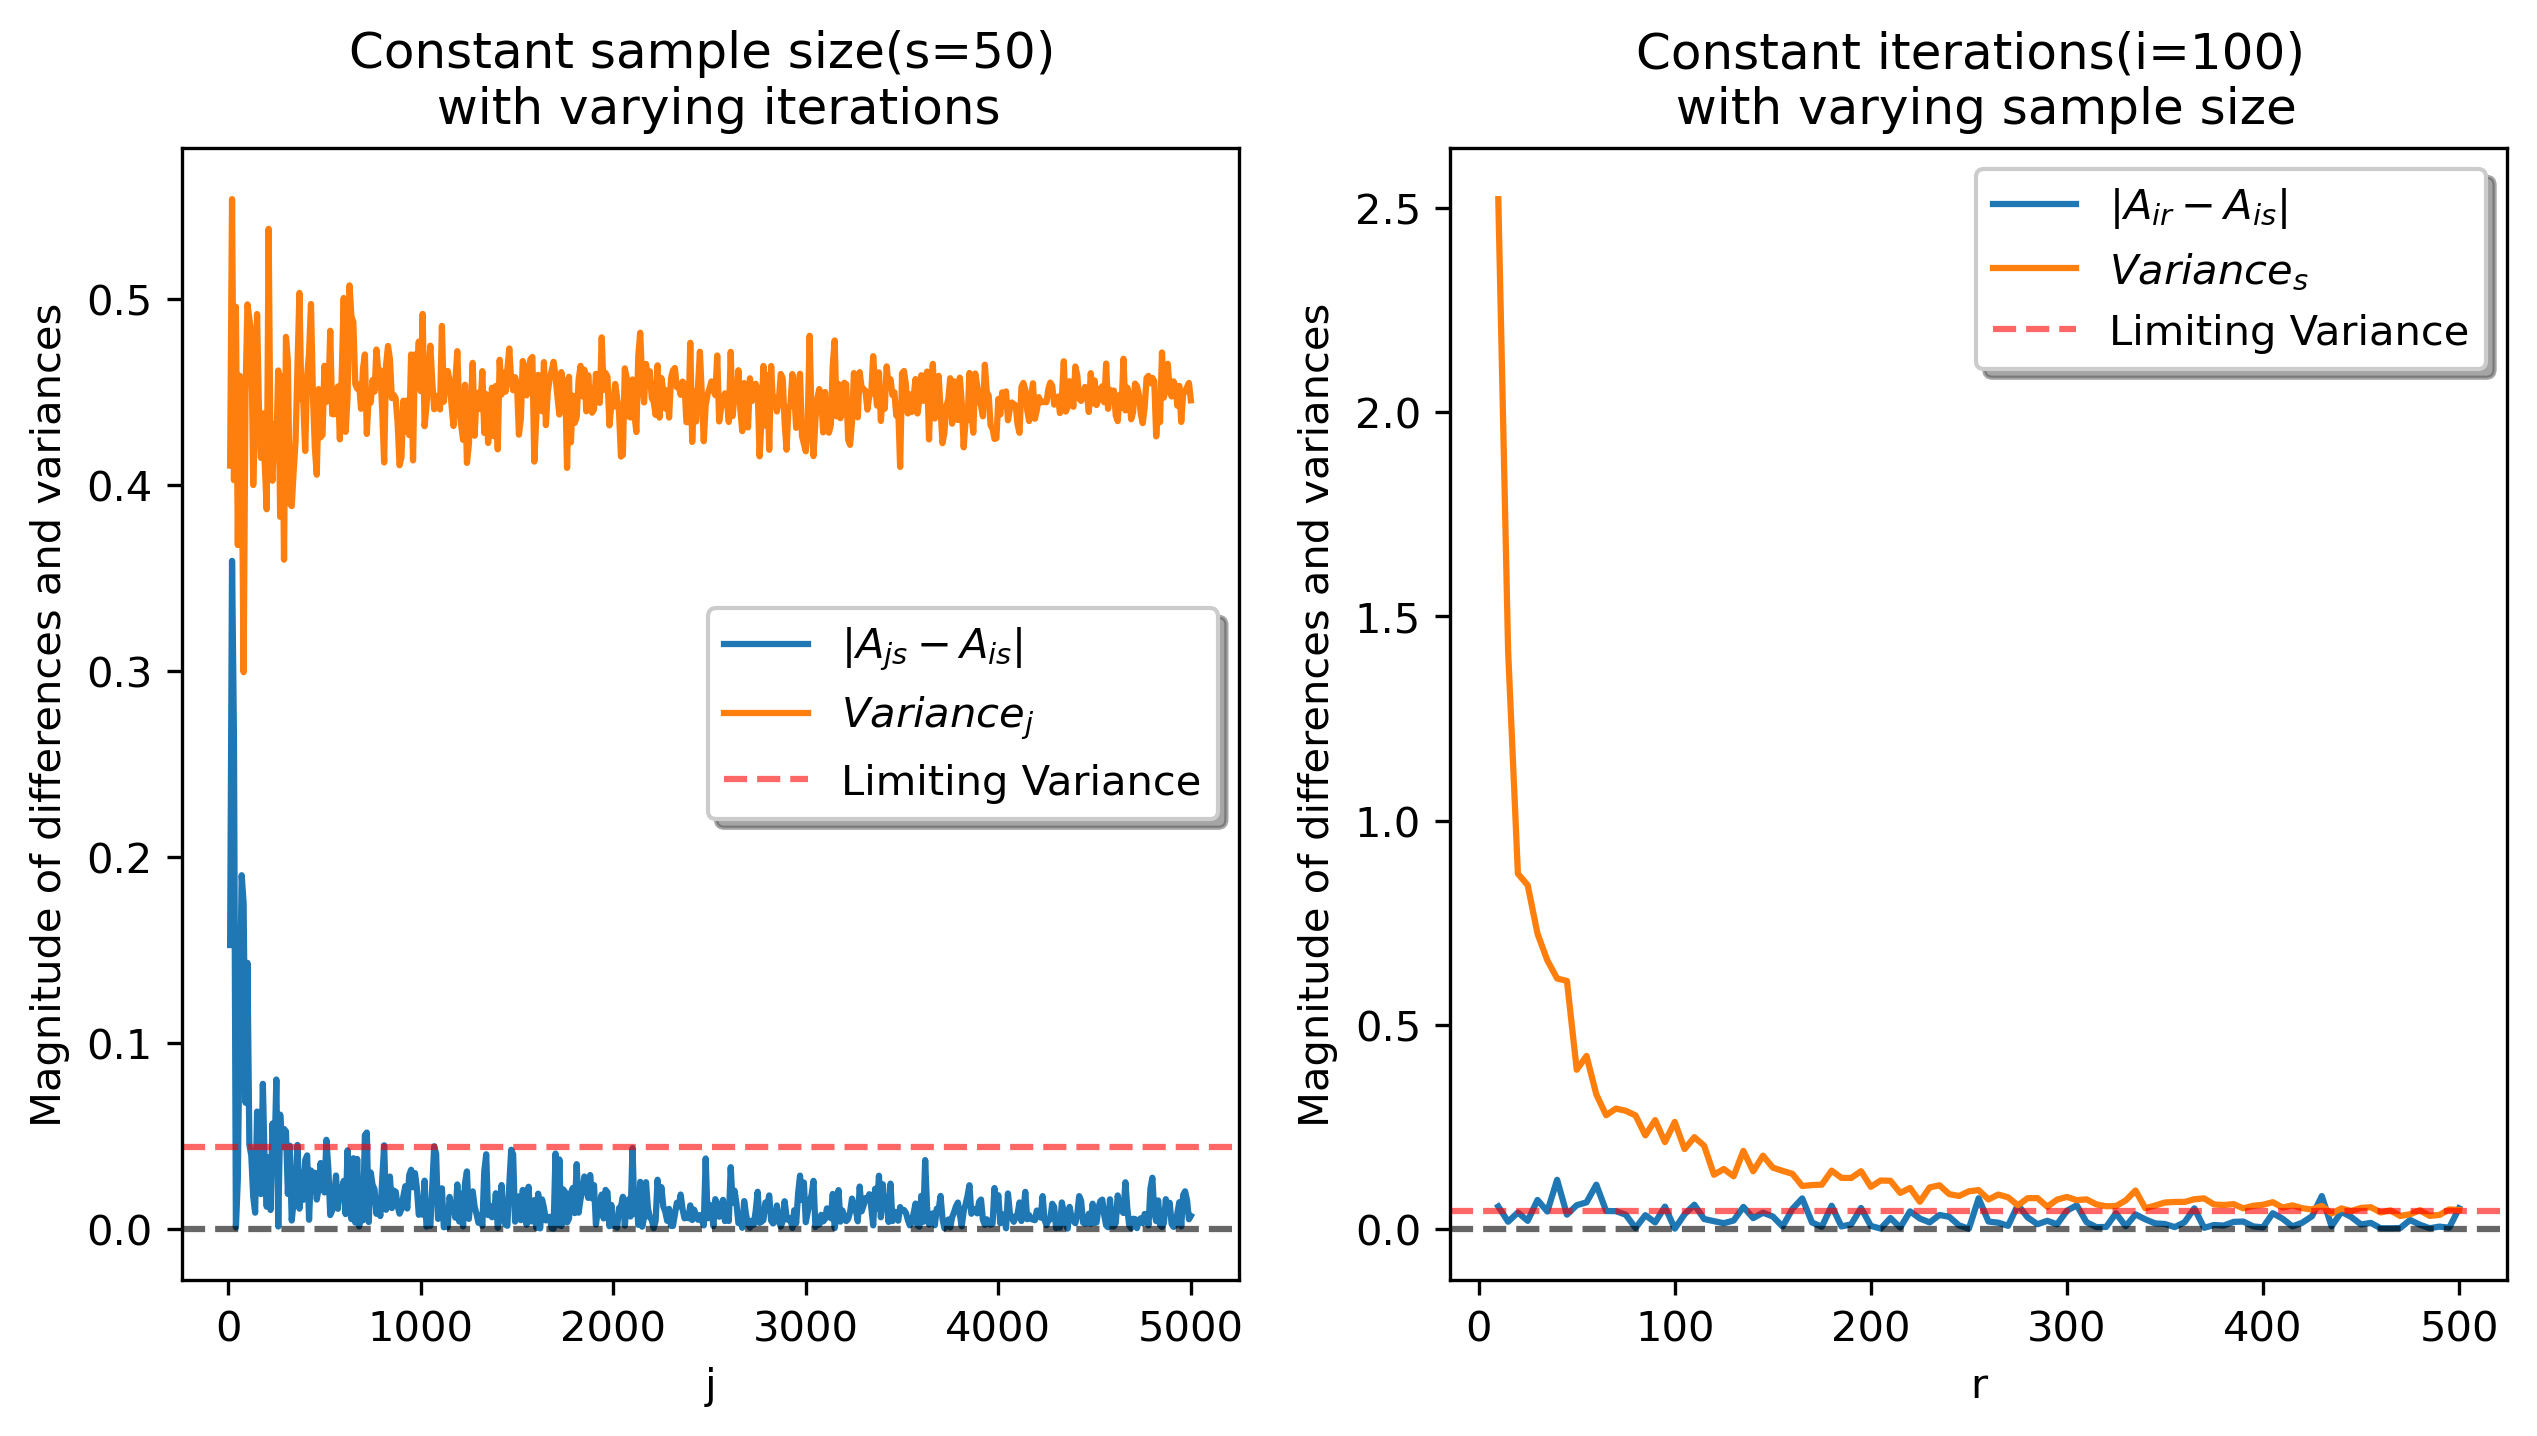

In [4]:
# MC Random Sampling
'''
Computationally Expensive to implement on a Intel Core i7-9750H CPU , 16 GB RAM system.
'''      

a = -2.0                         #upper limit of x & y coordinates
b = 2.0                          #lower limit of x & y coordinates
smax = 500                      # max samples drawn
imax = 5000                     # max no. of iterations
iterlist = np.arange(10,imax+10,10)
samplist = np.arange(10,smax+5,5)

def draw_randsamp(s):           #Random sampling function
    samp = []
    for i in range(s):                 
        X = a + (b-a)*random.uniform(0,1)
        Y = a + (b-a)*random.uniform(0,1)
        samp.append((X,Y)) 
    return samp


limit_areas = []           #areas when iterations -> imax & sample sizes -> smax

for j in range(imax):       #max iterations    
    areas = []
    k = 0
    sample = draw_randsamp(smax)    #max sample size 

    for i in (sample):
        if(mandel_val(i[0], i[1], 100)!= 0):
            k = k + 1

    limit_areas.append((k/smax)*16)

Am = np.mean(limit_areas)         #limiting area Am
Varm = np.var(limit_areas)        #limiting Variance
intv = st.norm.interval(alpha=0.95, loc=np.mean(limit_areas), scale=st.sem(limit_areas)) #95% confidence interval

print('Limiting Area: ',Am,'\nLimiting Variance: ',Varm,'\n95% confidence interval: ',intv)

Aj = []                         # areas for constant sample size
var_j = []                      # variances for constant sample size

for iter in iterlist:
    areas = []
    
    for j in range(iter):       #variable iterations
        k = 0
        sample = draw_randsamp(50)    #constant sample size of 50 

        for i in (sample):
            if(mandel_val(i[0], i[1], 100)!= 0):
                k = k + 1

        areas.append((k/50)*16)       #Monte carlo approximation. Total area enclosed by x=-2 , x=2 , y=2, y =-2 of 16 sq. units 
    Aj.append(np.mean(areas))
    var_j.append(np.var(areas))
    
As = []                           # areas for constant iterations
var_s = []                        # variances for constant iterations

for s in samplist:                #variable sample sizes
    areas = []
    
    for j in range(100):         #constant iterations of 100
        k = 0
        sample = draw_randsamp(s) 
        
        for i in (sample):
            if(mandel_val(i[0], i[1], 100)!= 0):
                k = k + 1

        areas.append((k/s)*16)
    As.append(np.mean(areas))
    var_s.append(np.var(areas))


diff_j = abs(Aj - Am)  
diff_s = abs(As - Am)  

plt.figure(figsize=(10,5),dpi =300)
plt.subplot(121)
plt.title('Constant sample size(s=50) \n with varying iterations')
plt.plot(iterlist, diff_j, label = r'$|A_{js}-A_{is}|$')
plt.plot(iterlist, var_j, label = r'$Variance_j$')
plt.axhline(y=0, c= 'k',ls = '--',alpha=0.6)
plt.axhline(y=Varm, c='r',ls = '--',alpha=0.6,label = 'Limiting Variance')
plt.ylabel('Magnitude of differences and variances')
plt.xlabel('j')
plt.legend(shadow=True)

plt.subplot(122)
plt.title('Constant iterations(i=100) \n with varying sample size')
plt.plot(samplist, diff_s, label = r'$|A_{ir}-A_{is}|$')
plt.plot(samplist, var_s, label = r'$Variance_s$')
plt.axhline(y=0, c ='k',ls = '--',alpha=0.6)
plt.axhline(y=Varm, c='r',ls = '--',alpha=0.6,label = 'Limiting Variance')
plt.ylabel('Magnitude of differences and variances')
plt.xlabel('r')
plt.legend(shadow=True)

plt.show()

Limiting Area:  1.5463615999999998 
Limiting Variance:  0.02560793964544 
95% confidence interval:  (1.5419255764667987, 1.5507976235332008)


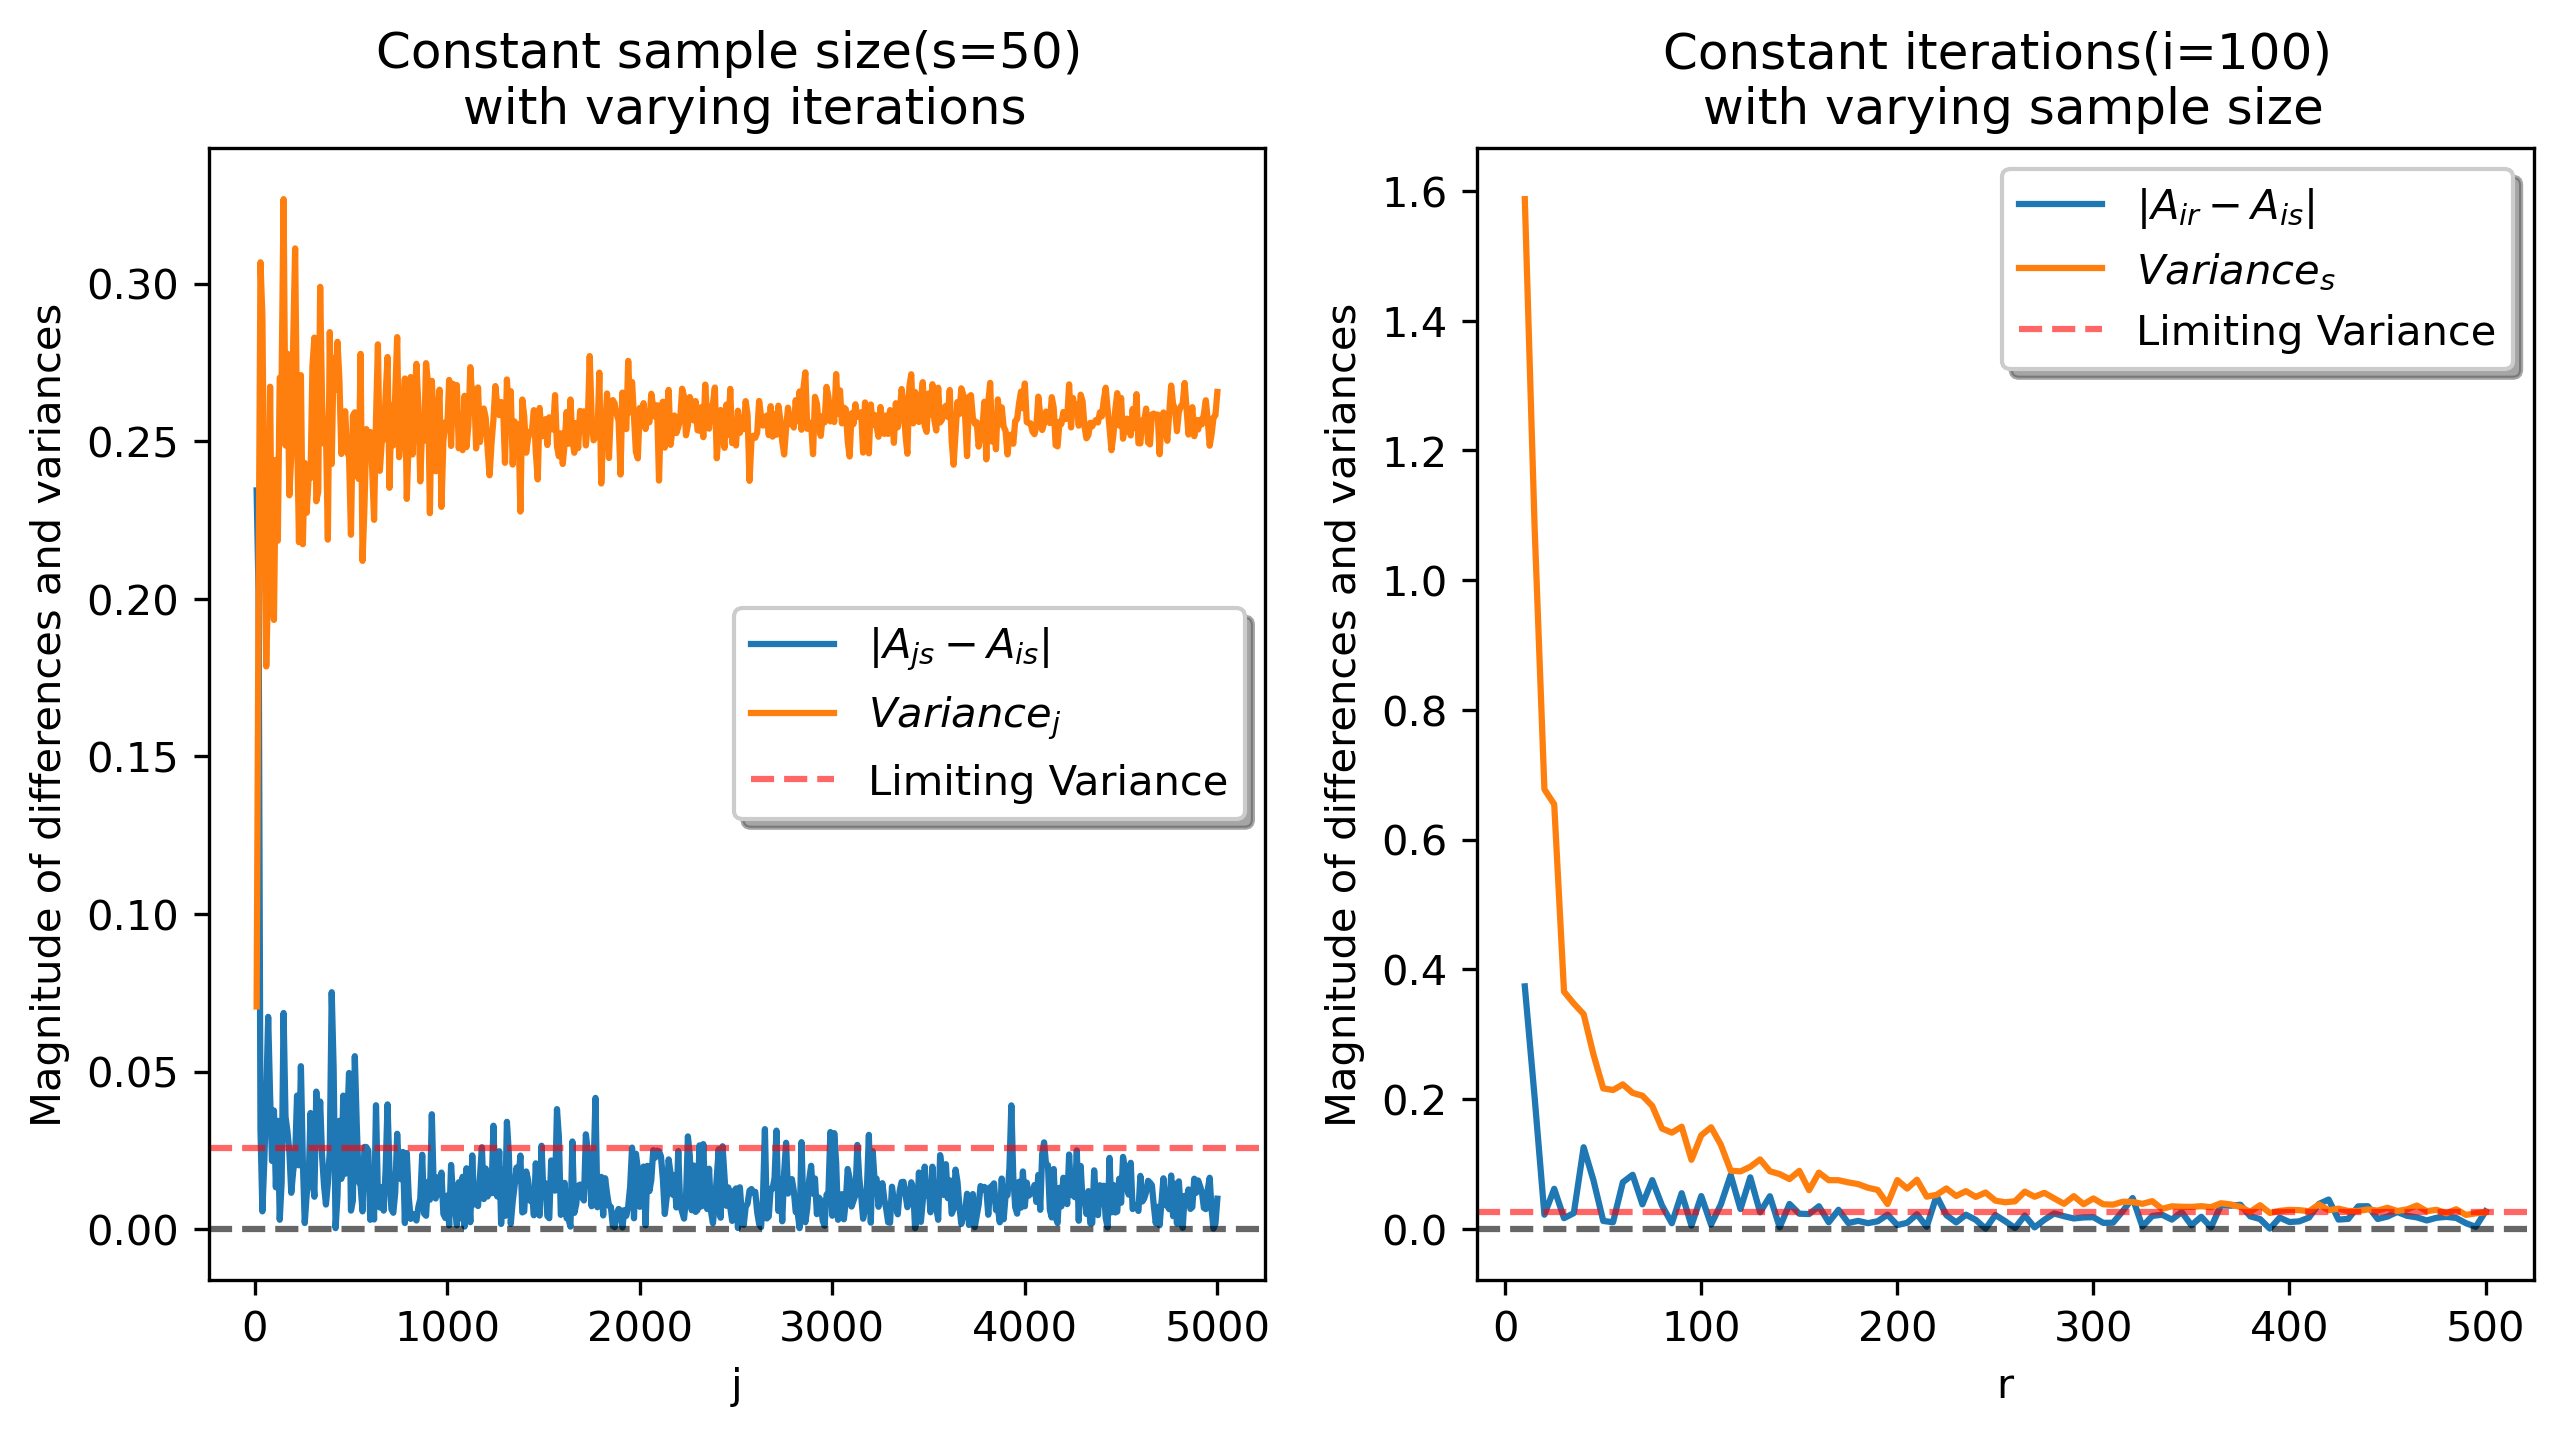

In [7]:
# MC LHS Sampling
'''
We lower the maximum samples and iterations and get lower variances and faster convergences which shows
LHS sampling is better.
'''

smax = 500                      # max samples 
imax = 5000                     # max no. of iterations
iterlist = np.arange(10,imax+10,10)
samplist = np.arange(10,smax+5,5)

def draw_lhsamp(s):             #LHS sampling function
    arr = np.array([[a, b], [a, b]])
    sampling = LHS(xlimits = arr)
    samp = sampling(s)
    return np.ndarray.tolist(samp)

limit_areas = []           #areas when iterations -> imax & sample sizes -> smax

for j in range(imax):       #max iterations  
    areas = []
    k = 0
    sample = draw_lhsamp(smax)    #max sample size 

    for i in (sample):
        if(mandel_val(i[0], i[1], 100)!= 0):
            k = k + 1

    limit_areas.append((k/smax)*16)

Am = np.mean(limit_areas)            #limiting area Am
Varm = np.var(limit_areas)           #limiting Variance
intv = st.norm.interval(alpha=0.95, loc=np.mean(limit_areas), scale=st.sem(limit_areas)) #95% confidence interval

print('Limiting Area: ',Am,'\nLimiting Variance: ',Varm,'\n95% confidence interval: ',intv)

Aj_lh = []                         # areas for constant sample size
var_j_lh = []                      # variances for constant sample size


for iter in iterlist:  
    areas = []
    
    for j in range(iter):       #variable iterations
        k = 0
        sample = draw_lhsamp(50)    #constant sample size of 50   
        
        for i in (sample):
            if(mandel_val(i[0], i[1], 100)!= 0):
                k = k + 1

        areas.append((k/50)*16)
        
    Aj_lh.append(np.mean(areas))
    var_j_lh.append(np.var(areas))
    
As_lh = []                           # areas for constant iterations
var_s_lh = []                        # variances for constant iterations


for s in samplist:                #variable sample sizes  
    areas = []
    
    for j in range(100):         #constant iterations of 100
        k = 0
        sample = draw_lhsamp(s)
   
        for i in (sample):
            if(mandel_val(i[0], i[1], 100)!= 0):
                k = k + 1

        areas.append((k/s)*16)
        
    As_lh.append(np.mean(areas))
    var_s_lh.append(np.var(areas))


diff_j_lh = abs(Aj_lh - Am)  
diff_s_lh = abs(As_lh - Am)  

plt.figure(figsize=(10,5),dpi =300)
plt.subplot(121)
plt.title('Constant sample size(s=50) \n with varying iterations')
plt.plot(iterlist, diff_j_lh, label = r'$|A_{js}-A_{is}|$')
plt.plot(iterlist, var_j_lh, label = r'$Variance_j$')
plt.axhline(y=0, c= 'k',ls = '--',alpha=0.6)
plt.axhline(y=Varm, c='r',ls = '--',alpha=0.6,label = 'Limiting Variance')
plt.ylabel('Magnitude of differences and variances')
plt.xlabel('j')
plt.legend(shadow=True)

plt.subplot(122)
plt.title('Constant iterations(i=100) \n with varying sample size')
plt.plot(samplist, diff_s_lh, label = r'$|A_{ir}-A_{is}|$')
plt.plot(samplist, var_s_lh, label = r'$Variance_s$')
plt.axhline(y=0, c ='k',ls = '--',alpha=0.6)
plt.axhline(y=Varm, c='r',ls = '--',alpha=0.6,label = 'Limiting Variance')
plt.ylabel('Magnitude of differences and variances')
plt.xlabel('r')
plt.legend(shadow=True)

plt.show()

Limiting Area:  1.546458979206049 
Limiting Variance:  0.00535138347047073 
95% confidence interval:  (1.5444311117803107, 1.5484868466317874)


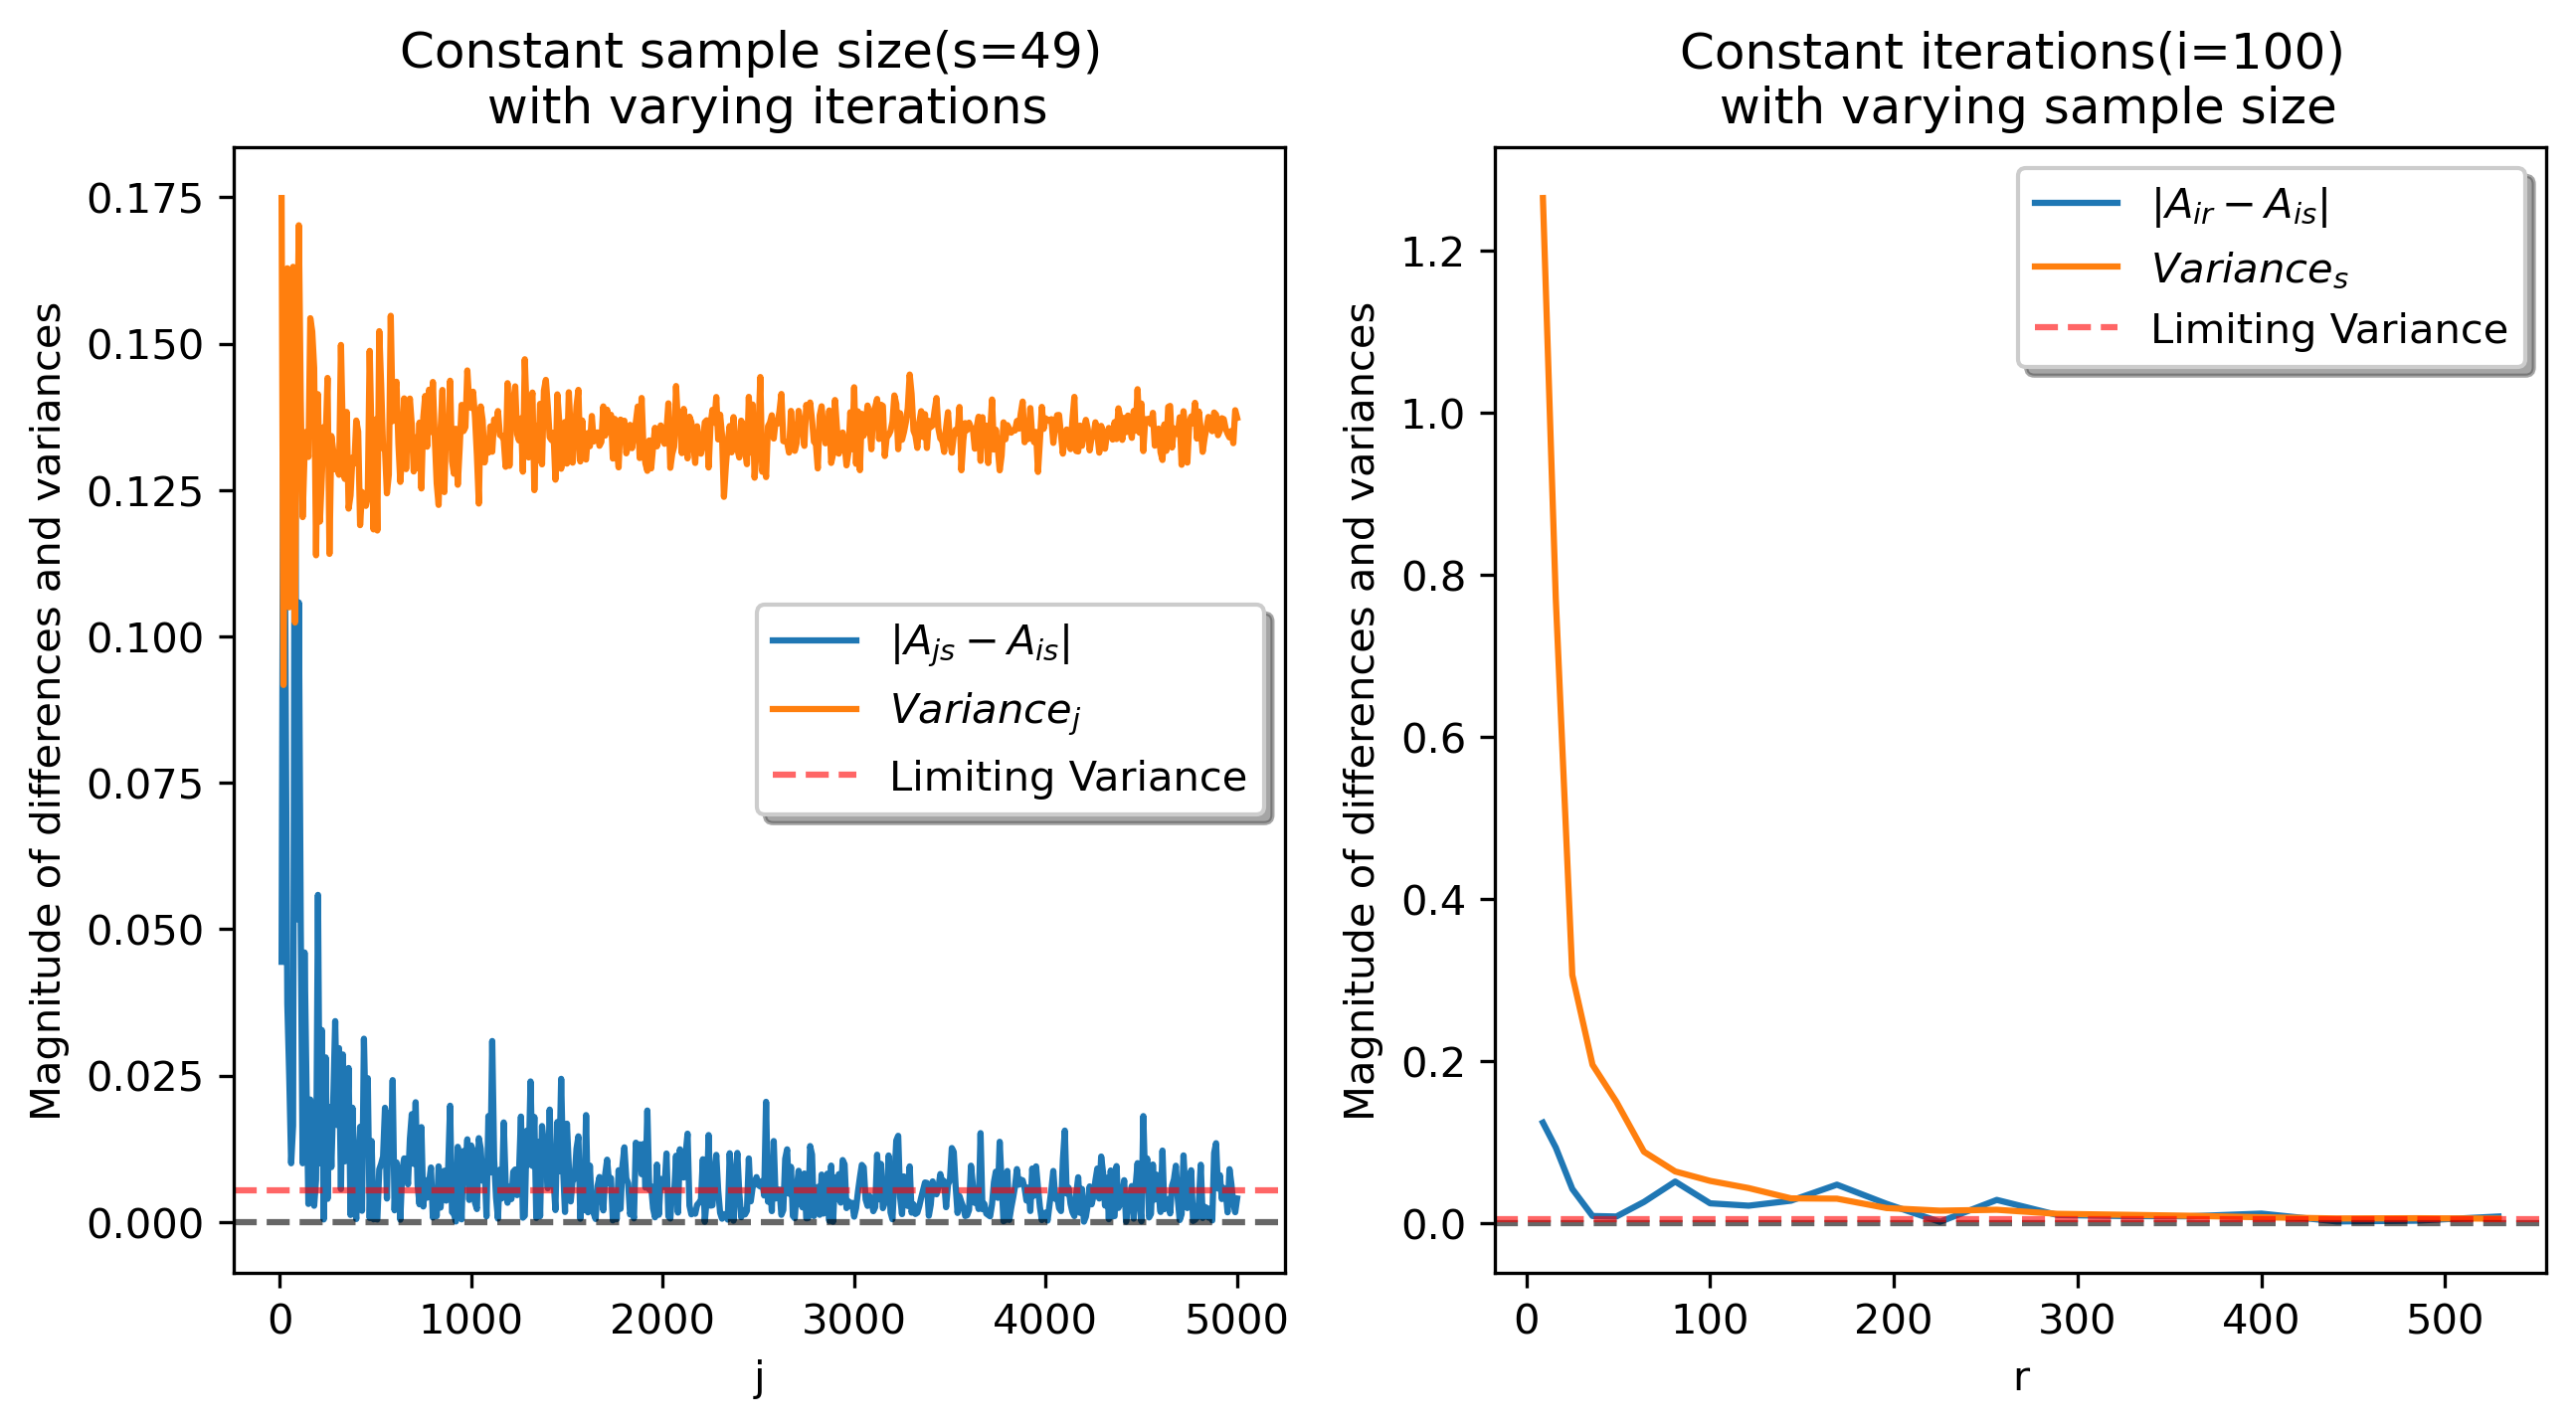

In [8]:
# MC Orthogonal Sampling
'''
We further lower the iterations and still get improved results which shows Orthogonal sampling is an improvement on LHS.

'''

smax = 23**2                      # max samples drawn is a perfect square to ensure we get a square matrix
imax = 5000                     # max no. of iterations
iterlist = np.arange(10,imax+10,10) 
samplist = np.array([n**2 for n in range(3,24)])   

def draw_orthosamp(samples):   #Orthogonal Sampling function 
    
    major = int(math.sqrt(samples))
    xlist = np.zeros((major,major))
    ylist = np.zeros((major,major))
    scale = 4/samples           # from -2 to 2 . 
    m = 0
    samp = []
    
    for i in range(major):
        
        for j in range (major):
            xlist[i][j] = ylist[i][j] = m
            m+=1
            
    for i in range(major):
        xlist[i] = np.random.permutation(xlist[i])
        ylist[i] = np.random.permutation(ylist[i])

    for i in range(major):

        for j in range(major):
            x = -2.0 + scale * (xlist[i][j] + np.random.random()) 
            y = -2.0 + scale * (ylist[j][i] + np.random.random())
            samp.append((x,y)) 
                
    return samp 


limit_areas = []

for j in range(imax):       #max iterations
    k = 0
    sample = draw_orthosamp(smax)  #max samples
    
    for i in (sample):
        if(mandel_val(i[0], i[1], 100)!= 0):
            k = k + 1

    limit_areas.append((k/smax)*16)

Am = np.mean(limit_areas)          #limiting area Am
Varm = np.var(limit_areas)          #limiting Variance
intv = st.norm.interval(alpha=0.95, loc=np.mean(limit_areas), scale=st.sem(limit_areas)) #95% confidence interval

print('Limiting Area: ',Am,'\nLimiting Variance: ',Varm,'\n95% confidence interval: ',intv)

Aj_lh = []                         # areas for constant sample size
var_j_lh = []                      # variances for constant sample size


for iter in iterlist:
    areas = []
    
    for j in range(iter):       #variable iterations
        k = 0
        sample = draw_orthosamp(7**2)    #constant sample size of 49
   
        for i in (sample):
            if(mandel_val(i[0], i[1], 100)!= 0):
                k = k + 1

        areas.append((k/49)*16)
    Aj_lh.append(np.mean(areas))
    var_j_lh.append(np.var(areas))
    
As_lh = []                           # areas for constant iterations
var_s_lh = []                        # variances for constant iterations


for s in samplist:                #variable sample sizes
    areas = []
    
    for j in range(100):         #constant iterations of 100
        k = 0
        sample = draw_orthosamp(s)
   
        for i in (sample):
            if(mandel_val(i[0], i[1], 100)!= 0):
                k = k + 1

        areas.append((k/s)*16)
    As_lh.append(np.mean(areas))
    var_s_lh.append(np.var(areas))


diff_j_lh = abs(Aj_lh - Am)  
diff_s_lh = abs(As_lh - Am)  

plt.figure(figsize=(10,5),dpi =300)
plt.subplot(121)
plt.title('Constant sample size(s=49) \n with varying iterations')
plt.plot(iterlist, diff_j_lh, label = r'$|A_{js}-A_{is}|$')
plt.plot(iterlist, var_j_lh, label = r'$Variance_j$')
plt.axhline(y=0, c= 'k',ls = '--',alpha=0.6)
plt.axhline(y=Varm, c='r',ls = '--',alpha=0.6,label = 'Limiting Variance')
plt.ylabel('Magnitude of differences and variances')
plt.xlabel('j')
plt.legend(shadow=True)

plt.subplot(122)
plt.title('Constant iterations(i=100) \n with varying sample size')
plt.plot(samplist, diff_s_lh, label = r'$|A_{ir}-A_{is}|$')
plt.plot(samplist, var_s_lh, label = r'$Variance_s$')
plt.axhline(y=0, c ='k',ls = '--',alpha=0.6)
plt.axhline(y=Varm, c='r',ls = '--',alpha=0.6,label = 'Limiting Variance')
plt.ylabel('Magnitude of differences and variances')
plt.xlabel('r')
plt.legend(shadow=True)

plt.show()